# BAKU - Time Measurement and Code Generation
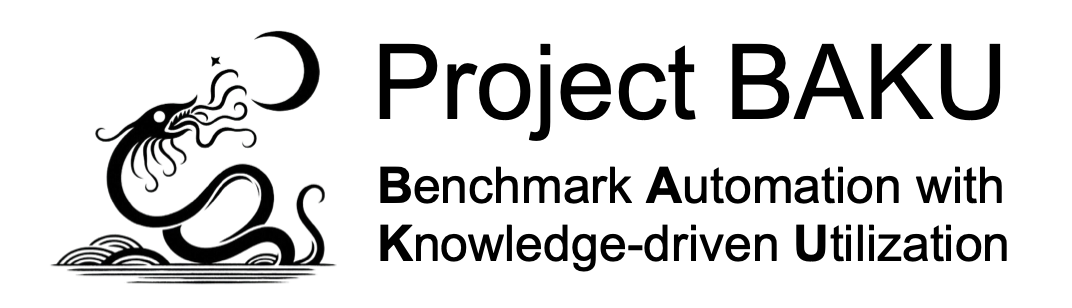

This notebook is designed for testing language models (LLMs). The primary objective is to collect data on the performance of LLMs regarding the time spent on code generation, the percentage of generated code that can be compiled, and to determine the asymptotic behavior of time concerning the maximum number of tokens in the networks. For better code organization, the code is structured in classes to ensure a functional pipeline.

### Imports

In [ ]:
from transformers import (
    AutoModelForCausalLM,
    AutoTokenizer
) #the model

import torch #for the model

import numpy as np #to better use of the arrays

import time #measure time

import matplotlib.pyplot as plt #plots

import pandas as pd #for csv

import statsmodels.api as sm #for run stats
import seaborn as sns

#Drive usage
# from google.colab import drive #to import the csv and other data
# from google.colab import auth
# from google.colab import userdata
# from googleapiclient.discovery import build
# from googleapiclient.http import MediaFileUpload


import subprocess #for write file...
import random
import string
import os
import sys

In [ ]:
sampling_path = '/content/drive/MyDrive/Colab_Notebooks/Baku/data/sampling.csv' #sampling data
models_path = '/content/drive/MyDrive/Colab_Notebooks/Baku/data/model_values.csv' #models sigle generation data
input_path = '/content/drive/MyDrive/Colab_Notebooks/Baku/data/code_add.csv' #inputs data
models_chain_path = '/content/drive/MyDrive/Colab_Notebooks/Baku/data/model_chain_programs.csv' #model chain generation data
chain_path = '/content/drive/MyDrive/Colab_Notebooks/Baku/data/chains.csv' #chain generation data

# Drive usage
# drive.mount('/content/drive')
# auth.authenticate_user()

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


### Classes

#### DataLoader

In [ ]:

class DataLoader:
    def __init__(self, data_path:str):
        try:
            self.data_path = data_path
            self.dataframe = pd.read_csv(data_path)
            print("Data Loaded.")
        except:
            raise Exception("Data couldn't be loaded.")


    def save(self):#Save the modified csv
        try:
            self.dataframe.to_csv(self.data_path, index=False)
            print("All data updated.")
        except:
            raise Exception("Data couldn't be uploaded.")

    def column_values(self,column_name):#Get a list of values in a column
        try:
            return self.dataframe[column_name].values
        except:
            raise Exception("Column must be wrong.")

    def new_row(self, new_values: list):#Matches two list to form a new data row
      if len(new_values) != len(self.dataframe.columns):
          raise ValueError("The number of values does not match the number of columns.")

      # Create a DataFrame from the new row values
      new_row = pd.DataFrame([dict(zip(self.dataframe.columns, new_values))])

      self.dataframe = pd.concat([self.dataframe, new_row], ignore_index=True)
      
    def update_row(self,index: str, new_values:list):
        if len(new_values) != len(self.dataframe.columns):
            raise ValueError("The number of values does not match the number of columns.")
        self.dataframe = self.dataframe.set_index(index) 
        self.dataframe.loc[new_values[0]] = new_values[1:]
        self.dataframe = self.dataframe.reset_index()


    def get_row(self, column: str, key: any):#Get all row using a key
        row = self.dataframe.set_index(column).loc[[key]]  # [[key]] to ensure good research
        values = row.values.flatten().tolist()
        return values

    def static_row_string(self,id,ignore_columns=""):#Chose a value to generate
        if(id==0):
            return "Impossible to pick the value."

        else:

            if not ignore_columns == "": #if there is a column...
                static = self.dataframe.drop(ignore_columns, axis=1).iloc[id]

            else:
                static = self.dataframe.iloc[id]

            static = static.to_string(index=False)
            return static

    def random_row_string(self,ignore_columns=""):#Random pick value to generates
        random = self.dataframe.sample()
        id = random.get('id').values[0]

        if not ignore_columns == "":#if there is a column...
            random = random.drop(ignore_columns, axis=1)

        random = random.to_string(index=False)
        return random,id


#### CodeGeneration

In [ ]:

class CodeGeneration:

    def __init__(self,model,model_name,tokenizer,data : DataLoader,input_str: str,input_id : int,
                 max_length : int, base_code: str = "", topology="regression"):
        self.model = model
        self.model_name = model_name
        self.data = data
        self.input_str = input_str
        self.max_length = max_length
        self.input_id = input_id
        self.tokenizer = tokenizer
        self.base_code = base_code

        if topology == "performance":
            self.template =  f"""
        Generate a C program optimized for the following Linux `perf` statistics:
        {self.input_str}

        - **Requirements**:
            1. The program must contain a main function that receives the data and invokes the processing logic.
            2. Address performance bottlenecks (e.g., cache misses, branch mispredictions) using:
            - Loop unrolling, SIMD intrinsics (AVX/SSE), memory alignment.
            - Data structure optimizations (e.g., cache-friendly layouts).
            3. **Fuzzer-Specific Constraints**:
            - Process raw bytes from `const uint8_t* data` and `size_t size` as input.
            - Avoid undefined behavior: validate buffer bounds, sanitize inputs.
            - Exclude I/O operations (e.g., `printf`, file access).
            4. Code Style:
            - Zero comments or explanations.
            - Use preprocessor directives only when critical (e.g., `#include <stdint.h>`).
            5. Enclose the code between <Program> tags.

        - **Output Format**:
            <Program>
            // C code here
            </Program>
        """

        else:
             self.template = f"""
        Complete the following C code, {self.input_str}:
        {self.base_code}


        - **Requirements**:
            1. The program must be a completicion to the base code.
            2. Enclose the code between <Program> tags.
        - **Output Format**:
            <Program>
            {self.base_code}
            </Program>
        """

        self.dif_seconds = 0
        self.ouput = ""
        self.program_name = ""
        self.program = ""


    def generate_code(self,response=True):#Measure time and generate the code
        input_time = time.time()
        inputs = self.tokenizer(self.template, return_tensors="pt").to(self.model.device)
        outputs = self.model.generate(**inputs, max_length=self.max_length) #model output
        output_time = time.time()

        self.dif_seconds = (output_time - input_time) #time measure
        decoded_output = self.tokenizer.decode(outputs[0], skip_special_tokens=True)
        self.output = decoded_output

        if(response):
            print('The output was:' + decoded_output)
            print(f'Time spend in the code generation: {self.dif_seconds}')


    def get_output_list(self):#Return the data from the program generation
        if (self.program_name == "") or (self.program == ""):
            program = self.program_extratcion()

        if(self.base_code in self.program):#Do not accept base code as a generated code

            len_program = len(self.tokenizer.encode(self.program)) #count the amount of tokens in the program
            return [self.model_name,
                    self.dif_seconds,
                    self.program_name,
                    self.input_id,
                    -1]

        len_program = len(self.tokenizer.encode(self.program)) #count the amount of tokens in the program
        return [self.model_name,
                self.dif_seconds,
                self.program_name,
                self.input_id,
                len_program]


    def program_extratcion(self):#Return the program generated"
        self.name_generator()

        if self.program == "":
            final_program = ""
            suboutput_list = self.output.split("<Program>")

            for subprogram in (suboutput_list):
              if "</Program>" in subprogram:
                program = subprogram.split("</Program>")[0]

                if program.count('{') == program.count('}'):
                        final_program = program

            self.program = final_program

        return self.program


    def name_generator(self,size=4): #Randomly generate a new file name

        if self.program_name == "" :
            chars=string.ascii_uppercase + string.digits
            random_name = ''.join(random.choice(chars) for _ in range(size))
            while random_name in self.data.column_values('code_name'):
                random_name = ''.join(random.choice(chars) for _ in range(size))
            self.program_name = random_name




#### Generattion Pipeline

In [ ]:

class GenerationPipeline: #TODO: setup the file generation to local as well
    def __init__(
            self,
            model: object,
            model_name: str,
            tokenizer: object,
            sampling_data_path: str,
            models_data_path: str,
            input_data_path: str,
            models_chain_path: str,
            chains_data_path: str,
            topology: str = 'regression'  # Nome corrigido
        ):
        self.model = model
        self.model_name = model_name
        self.tokenizer = tokenizer
        self.input_data = DataLoader(input_data_path)
        self.models_data = DataLoader(models_data_path)
        self.sampling_data = DataLoader(sampling_data_path)
        self.models_chain = DataLoader(models_chain_path)
        self.chains_data = DataLoader(chains_data_path)

        if topology == "performance":
            self.ignore_coluns = ['Suite','Program','id']

        else:
            self.ignore_coluns = ['id','type']

        self.topology = topology

    def upload_single_file_to_drive(self,code_name,program):#Upload file to drive for colab
        try:
            folder_id = '' #need to add the folder id
            local_file_path = f"/content/{code_name}.c"


            with open(local_file_path, "w") as file:
             file.write(program)


            file_metadata = {
                'name': f'{code_name}.c',
                'parents': [folder_id]
            }

            media = MediaFileUpload(local_file_path, mimetype='text/plain')
            service = build('drive', 'v3')
            uploaded_file = service.files().create(body=file_metadata, media_body=media, fields='id').execute()

            print(f"File uploaded successfully. File ID: {uploaded_file.get('id')}")
        except Exception as e:
            print(f"File could not be uploaded. ERROR: {e}")

    def upload_chain_file_to_drive(self,program,folder_id,folder_name,n):#Upload file to drive for colab
        try:
            local_file_path = f"/content/{folder_name}{n}.c"


            with open(local_file_path, "w") as file:
             file.write(program)


            file_metadata = {
                'name': f'{folder_name}{n}.c',
                'parents': [folder_id]
            }

            media = MediaFileUpload(local_file_path, mimetype='text/plain')
            service = build('drive', 'v3')
            uploaded_file = service.files().create(body=file_metadata, media_body=media, fields='id').execute()

            print(f"File uploaded successfully. File ID: {uploaded_file.get('id')}")
        except Exception as e:
            print(f"File could not be uploaded. ERROR: {e}")


    def folder_generator(self,parent_folder_id,size=4):
        chars=string.ascii_uppercase
        random_name = ''.join(random.choice(chars) for _ in range(size))
        while random_name in self.chains_data.column_values('folder_id'):
            random_name = ''.join(random.choice(chars) for _ in range(size))

        folder_metadata = {
            'name': random_name,
            'mimeType': 'application/vnd.google-apps.folder'
        }

        if parent_folder_id:
            folder_metadata['parents'] = [parent_folder_id]

        service = build('drive', 'v3')
        created_folder = service.files().create(
            body=folder_metadata,
            fields='id'
        ).execute()

        return created_folder.get('id'),random_name

    def find_folder(self, parent_folder_id: str, folder_name: str):
        try:
            drive_service = build('drive', 'v3')

            query = f"'{parent_folder_id}' in parents and name = '{folder_name}' and mimeType = 'application/vnd.google-apps.folder'"

            results = drive_service.files().list(
                q=query,
                fields='files(id, name)'
            ).execute()

            folders = results.get('files', [])

            if folders:
                return folders[0]['id'], folders[0]['name']
            else:
                return None, None

        except Exception as e:
            raise f"Folder coulnd't been founded: {e}"

    def single_code_generation(self, max_len: int, static: bool = False, id: int = 0) -> float:#Single Program Generation
        try:
            input_value = ""

            if static:#Static Value
                input_value,input_id = self.input_data.static_row_string(id,self.ignore_coluns)

            else:#Random
                input_value,input_id = self.input_data.random_row_string(self.ignore_coluns)


            base_code = """ int f(int a) {
                return 0;
                }"""

            generator = CodeGeneration(
            model=self.model,
            model_name=self.model_name,
            tokenizer=self.tokenizer,
            data=self.models_data,
            input_str=input_value,
            input_id=input_id,
            max_length=max_len,
            base_code=base_code,
            topology=self.topology
            )

            generator.generate_code()

            program = generator.program_extratcion()

            output_list = generator.get_output_list()

            if(output_list[4] > 0):
                self.upload_single_file_to_drive(output_list[2],program)#Save generation

            self.models_data.new_row(output_list)
            self.models_data.save()

            print("Program Generated:\n" + program)
            return output_list[1]
        except Exception as e:
            print(f"ERRO: {e}")



    def single_sampling(self,first_max_length=1024,max_lenght_pow=1,sample=12):#Simulate different generation for time measure

        current_max_length = first_max_length#Begin with some length
        time_array = np.array([])

        for _ in range(max_lenght_pow):

            for _ in range(sample):
                time_temp = self.single_code_generation(current_max_length) #time spent

                time_array = np.append(time_array,time_temp)


            sampling_output = [self.model_name,
                                 np.mean(time_array),
                                 np.std(time_array),
                                 sample,
                                 current_max_length
                                ,np.min(time_array),
                                 np.max(time_array)]


            self.sampling_data.new_row(sampling_output)
            self.sampling_data.save()

            time_array = np.empty(0)

            current_max_length *= 2 #make it double beacause could grow better

        print("Sampling Done!")

    def chain_code_generation(self, max_len: int, n: int = 1) -> float:
        try:
            ac_time = 0
            base_code = """ int f(int a) {
                    return 0;
                    }"""
            i = 0
            last_code_id = ''
            folder_id,folder_name = self.folder_generator('1y_BZ7M_Rpq7q4TEoRQiGMkfDWhR0okan')
            for _ in range(n):
                input_value,input_id = self.input_data.random_row_string(self.ignore_coluns)

                generator = CodeGeneration(
                model=self.model,
                model_name=self.model_name,
                tokenizer=self.tokenizer,
                data=self.models_data,
                input_str=input_value,
                input_id=input_id,
                max_length=max_len,
                base_code=base_code,
                topology=self.topology
                )

                generator.generate_code()

                program = generator.program_extratcion()

                output_list = generator.get_output_list()


                if(output_list[4] > 0):
                    if i==0:
                        last_code_id = 'None'
                    else:
                        last_code_id = f'{folder_name}{i}'

                    i = i + 1

                    output_list.append(last_code_id)
                    output_list.append(folder_name)
                    output_list[2] = f'{folder_name}{i}'

                    self.models_chain.new_row(output_list)
                    self.models_chain.save()


                    self.upload_chain_file_to_drive(program,folder_id,folder_name,i)


                    ac_time = ac_time + output_list[1]
                    base_code = program

                    print("Program Generated:\n" + program)

            #folder_id,num_regression,time_spent,mean_time_program,std_time,compilation
            rows_chain = [folder_name,i,ac_time,0,0,"False"]
            self.chains_data.new_row(rows_chain)
            self.chains_data.save()

            return ac_time
        except Exception as e:
            print(f"ERRO: {e}")

    def chain_sampling(self,first_max_length=1024,max_lenght_pow=1,sample=12):

        current_max_length = first_max_length#Begin with some length
        time_array = np.array([])
        iterations = random.randint(1,15)

        for _ in range(max_lenght_pow):

            for _ in range(sample):
                time_temp = self.chain_code_generation(current_max_length,iterations) #time spent

                time_array = np.append(time_array,time_temp)


            sampling_output = [self.model_name,
                                 np.mean(time_array),
                                 np.std(time_array),
                                 sample,
                                 current_max_length
                                ,np.min(time_array),
                                 np.max(time_array)]


            self.sampling_data.new_row(sampling_output)
            self.sampling_data.save()

            time_array = np.empty(0)

            current_max_length *= 2 #make it double beacause could grow better

        print("Sampling Done!")




    def continue_chain(self, folder_chain: str , max_len: int, n: int = 1) -> float:
        try:
            chain_values = self.chains_data.get_row('folder_id',folder_chain)

            base_code = """ int f(int a) {
                    return 0;
                    }"""

            with open(f'/content/drive/My Drive/Colab_Notebooks/Baku/codes/{folder_chain}/{folder_chain}{chain_values[0]}.c', 'r') as f:
                base_code = f.read()

            ac_time = chain_values[1]
            i = chain_values[0]
            last_code_id = ''
            folder_id,folder_name = self.find_folder('1y_BZ7M_Rpq7q4TEoRQiGMkfDWhR0okan',folder_chain)
            for _ in range(n):
                input_value,input_id = self.input_data.random_row_string(self.ignore_coluns)

                generator = CodeGeneration(
                model=self.model,
                model_name=self.model_name,
                tokenizer=self.tokenizer,
                data=self.models_data,
                input_str=input_value,
                input_id=input_id,
                max_length=max_len,
                base_code=base_code,
                topology=self.topology
                )

                generator.generate_code()

                program = generator.program_extratcion()

                output_list = generator.get_output_list()


                if(output_list[4] > 0):
                    if i==0:
                        last_code_id = 'None'
                    else:
                        last_code_id = f'{folder_name}{i}'

                    i = i + 1

                    output_list.append(last_code_id)
                    output_list.append(folder_name)
                    output_list[2] = f'{folder_name}{i}'

                    self.models_chain.new_row(output_list)
                    self.models_chain.save()


                    self.upload_chain_file_to_drive(program,folder_id,folder_name,i)


                    ac_time = ac_time + output_list[1]
                    base_code = program

                    print("Program Generated:\n" + program)

            #folder_id,num_regression,time_spent,mean_time_program,std_time,compilation
            rows_chain = [folder_name,i,ac_time,0,0,"False"]
            self.chains_data.update_row("folder_id",rows_chain)
            self.chains_data.save()

            return ac_time
        except Exception as e:
            print(f"ERRO: {e}")


### AI Config

In [ ]:
inputss = DataLoader(input_path)

Data Loaded.


In [ ]:
model_name = "meta-llama/Meta-Llama-3.1-8B-Instruct" #Obs: Run in free plan; Some alucinations (tuning?);
# model_name = 'deepseek-ai/DeepSeek-Coder-V2-Lite-Instruct' #Obs: Don't Run in free; Clean code; Faster;
# model_name = 'bigcode/starcoder2-7b' #Obs: Lazy; Alucinations; Bigger than llama;
# model_name = 'facebook/llvm-compiler-7b'#Need to be test properly

tokenizer = AutoTokenizer.from_pretrained(
    model_name,
    trust_remote_code = True
)

model = AutoModelForCausalLM.from_pretrained(
    model_name,
    trust_remote_code = True,
    torch_dtype = torch.bfloat16
).cuda()

input_text = "write a quick sort algorithm in C"
inputs = tokenizer(input_text, return_tensors="pt").to(model.device)
outputs = model.generate(**inputs, max_length=128)
print(tokenizer.decode(outputs[0], skip_special_tokens=True))

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/55.4k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/9.09M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/296 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/855 [00:00<?, ?B/s]

model.safetensors.index.json:   0%|          | 0.00/23.9k [00:00<?, ?B/s]

model-00001-of-00004.safetensors:   0%|          | 0.00/4.98G [00:00<?, ?B/s]

model-00002-of-00004.safetensors:   0%|          | 0.00/5.00G [00:00<?, ?B/s]

model-00003-of-00004.safetensors:   0%|          | 0.00/4.92G [00:00<?, ?B/s]

model-00004-of-00004.safetensors:   0%|          | 0.00/1.17G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/184 [00:00<?, ?B/s]

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


write a quick sort algorithm in C
Here is a quick sort algorithm in C:
```c
#include <stdio.h>
#include <stdlib.h>

// Function to swap two elements
void swap(int *a, int *b) {
    int temp = *a;
    *a = *b;
    *b = temp;
}

// Function to partition the array
int partition(int arr[], int low, int high) {
    int pivot = arr[high];
    int i = low - 1;

    for (int j = low; j < high; j++) {
        if (arr[j] <


### Generation (Single tests and simulation)

In [ ]:
pipeline = GenerationPipeline(model, model_name, tokenizer,sampling_path,models_path,input_path,models_chain_path,chain_path)
seconds = pipeline.single_code_generation(512)
seconds

In [ ]:
#pipeline = GenerationPipeline(model, model_name, tokenizer,sampling_path,models_path,input_path,models_chain_path,chain_path)
#pipeline = pipeline.chain_code_generation(512,6)

In [ ]:
pipeline = GenerationPipeline(model, model_name, tokenizer,sampling_path,models_path,input_path,models_chain_path,chain_path)
pipeline.chain_sampling(512,2,3,5)

Data Loaded.
Data Loaded.
Data Loaded.
Data Loaded.
Data Loaded.


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


The output was:
        Complete the following C code,                                               value
add a conditional statement with a statement inside:
         int f(int a) {
                    return 0;
                    }


        - **Requirements**:
            1. The program must be a completicion to the base code.
            2. Enclose the code between <Program> tags.
        - **Output Format**:
            <Program>
             int f(int a) {
                    return 0;
                    }
            </Program>
         <Program>
             int f(int a) {
                    if (a > 0) {
                    return a;
                    }
                    }
            </Program>
            Here is the corrected code:


<Program>
    int f(int a) {
        if (a > 0) {
            return a;
        }
        return 0;
    }
</Program> 
Explanation:
The code is a completion of the base code. It adds a conditional statement with a statement inside. The st

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


File uploaded successfully. File ID: 1QzjHmbrmFuqSqmZLjjYgdxezojdDpAsF
Program Generated:

    int f(int a) {
        if (a > 0) {
            return a;
        }
        return 0;
    }



Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


The output was:
        Complete the following C code,                                    value
“make a dead condition more complicated”:
        
    int f(int a) {
        if (a > 0) {
            return a;
        }
        return 0;
    }



        - **Requirements**:
            1. The program must be a completicion to the base code.
            2. Enclose the code between <Program> tags.
        - **Output Format**:
            <Program>
            
    int f(int a) {
        if (a > 0) {
            return a;
        }
        return 0;
    }

            </Program>
        


Here is the code that meets the specifications:


<Program>
    
    int f(int a) {
        if (a > 0) {
            return a;
        }
        return 0;
    }
    int g(int a) {
        if (a > 0) {
            return a;
        }
        return a * 2;
    }
    int h(int a) {
        if (a > 0) {
            return a;
        }
        return a + 1;
    }
    int main() {
        int x = 5;
        in

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


File uploaded successfully. File ID: 1fwR7WjDg10UwPG-X27S4u7Nx_QAv9DRR
Program Generated:

int f(int a) {
    if (a > 0) {
        return a;
    }
    return 0;
}

The output was:
        Complete the following C code,               value
“add pointers code”:
        
int f(int a) {
    if (a > 0) {
        return a;
    }
    return 0;
}



        - **Requirements**:
            1. The program must be a completicion to the base code.
            2. Enclose the code between <Program> tags.
        - **Output Format**:
            <Program>
            
int f(int a) {
    if (a > 0) {
        return a;
    }
    return 0;
}

            </Program>
        



Here is the code that meets the requirements:

<Program>
int f(int a) {
    int *ptr = &a;
    int b = *ptr;
    if (b > 0) {
        return b;
    }
    return 0;
}
</Program>
Time spend in the code generation: 2.3962056636810303
All data updated.


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


File uploaded successfully. File ID: 1lpNMBkDuCrB1LoZylrC0tLF-F3EeEfa9
Program Generated:

int f(int a) {
    int *ptr = &a;
    int b = *ptr;
    if (b > 0) {
        return b;
    }
    return 0;
}



Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


The output was:
        Complete the following C code,               value
“add pointers code”:
        
int f(int a) {
    int *ptr = &a;
    int b = *ptr;
    if (b > 0) {
        return b;
    }
    return 0;
}



        - **Requirements**:
            1. The program must be a completicion to the base code.
            2. Enclose the code between <Program> tags.
        - **Output Format**:
            <Program>
            
int f(int a) {
    int *ptr = &a;
    int b = *ptr;
    if (b > 0) {
        return b;
    }
    return 0;
}

            </Program>
         - **Constraints**:
            None
        - **Example Input/Output**:
            None

<Program>
int f(int a) {
    int *ptr = &a;
    int b = *ptr;
    if (b > 0) {
        return b;
    }
    return 0;
}
</Program>  <Program>
int f(int a) {
    int *ptr = &a;
    int b = *ptr;
    if (b > 0) {
        return b;
    }
    return 0;
}
</Program>  <Program>
int f(int a) {
    int *ptr = &a;
    int b = *ptr;
    if (b >

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


File uploaded successfully. File ID: 1tFmuD4wQcBPrfAdGnynMO1n92CMDvXaE
Program Generated:

            
int f(int a) {
    int *ptr = &a;
    int b = *ptr;
    if (b > 0) {
        if (b % 2 == 0) {
            return b * 2;
        }
        return b;
    }
    return 0;
}

            


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


The output was:
        Complete the following C code,                                               value
add a conditional statement with a statement inside:
        
            
int f(int a) {
    int *ptr = &a;
    int b = *ptr;
    if (b > 0) {
        if (b % 2 == 0) {
            return b * 2;
        }
        return b;
    }
    return 0;
}

            


        - **Requirements**:
            1. The program must be a completicion to the base code.
            2. Enclose the code between <Program> tags.
        - **Output Format**:
            <Program>
            
            
int f(int a) {
    int *ptr = &a;
    int b = *ptr;
    if (b > 0) {
        if (b % 2 == 0) {
            return b * 2;
        }
        return b;
    }
    return 0;
}

            
            </Program>
         - **Explanation**:
            The given code is a function `f` that takes an integer `a` as input. It first creates a pointer `ptr` to the variable `a` and then assigns the value of `a

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


File uploaded successfully. File ID: 1qLjf_a4GbBBI7swwMf7ZsQj-i76-_JT6
Program Generated:

                int f(int a) {
                    int *ptr = &a;
                    int b = *ptr;
                    if (b > 0) {
                        if (b % 2 == 0) {
                            return b * 2;
                        }
                        return b;
                    }
                    while (1 + 1 == 2 && 2 * b > 0) {
                        b = b * b;
                        if (b > 1000000) {
                            break;
                        }
                    }
                    return 0;
                }
                


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


The output was:
        Complete the following C code,                                    value
“make a dead condition more complicated”:
        
                int f(int a) {
                    int *ptr = &a;
                    int b = *ptr;
                    if (b > 0) {
                        if (b % 2 == 0) {
                            return b * 2;
                        }
                        return b;
                    }
                    while (1 + 1 == 2 && 2 * b > 0) {
                        b = b * b;
                        if (b > 1000000) {
                            break;
                        }
                    }
                    return 0;
                }
                


        - **Requirements**:
            1. The program must be a completicion to the base code.
            2. Enclose the code between <Program> tags.
        - **Output Format**:
            <Program>
            
                int f(int a) {
                    int *

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


The output was:
        Complete the following C code,                                    value
“make a dead condition more complicated”:
        
                int f(int a) {
                    int *ptr = &a;
                    int b = *ptr;
                    if (b > 0) {
                        if (b % 2 == 0) {
                            return b * 2;
                        }
                        return b;
                    }
                    while (1 + 1 == 2 && 2 * b > 0) {
                        b = b * b;
                        if (b > 1000000) {
                            break;
                        }
                    }
                    return 0;
                }
                


        - **Requirements**:
            1. The program must be a completicion to the base code.
            2. Enclose the code between <Program> tags.
        - **Output Format**:
            <Program>
            
                int f(int a) {
                    int *

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


The output was:
        Complete the following C code,                   value
“add struct code usage”:
        
                int f(int a) {
                    int *ptr = &a;
                    int b = *ptr;
                    if (b > 0) {
                        if (b % 2 == 0) {
                            return b * 2;
                        }
                        return b;
                    }
                    while (1 + 1 == 2 && 2 * b > 0) {
                        b = b * b;
                        if (b > 1000000) {
                            break;
                        }
                    }
                    return 0;
                }
                


        - **Requirements**:
            1. The program must be a completicion to the base code.
            2. Enclose the code between <Program> tags.
        - **Output Format**:
            <Program>
            
                int f(int a) {
                    int *ptr = &a;
                    int 

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


The output was:
        Complete the following C code,                               value
“make a condition more complicated”:
         int f(int a) {
                    return 0;
                    }


        - **Requirements**:
            1. The program must be a completicion to the base code.
            2. Enclose the code between <Program> tags.
        - **Output Format**:
            <Program>
             int f(int a) {
                    return 0;
                    }
            </Program>
         If the code does not match the given requirements, the output will be “Invalid code”.
            - **Constraints**:
                - The code must be in C.
                - The code must be a function.
                - The code must return an integer.
            - **Example**:
                For the given code, the output should be the same code with the addition of a condition to make it more complicated.
                The condition should be that the function shoul

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


File uploaded successfully. File ID: 1rM9sLqzX3057nlerUejKi4399u8YKVPM
Program Generated:

int f(int a) {
                    return 0;
                    }
            
The output was:
        Complete the following C code,                               value
“make a condition more complicated”:
        
int f(int a) {
                    return 0;
                    }
            


        - **Requirements**:
            1. The program must be a completicion to the base code.
            2. Enclose the code between <Program> tags.
        - **Output Format**:
            <Program>
            
int f(int a) {
                    return 0;
                    }
            
            </Program>
        


        Here is the completed C code:
<Program>
            
int f(int a) {
    if (a > 0 && a < 10) {
        return 0;
    } else if (a >= 10 && a <= 20) {
        return 1;
    } else {
        return 2;
    }
}
            
</Program>

This code adds a condition to the functi

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


File uploaded successfully. File ID: 1Ij_X5TC9SomKKh7SiY-0ftKC_KZra015
Program Generated:

            
int f(int a) {
    if (a > 0 && a < 10) {
        return 0;
    } else if (a >= 10 && a <= 20) {
        return 1;
    } else {
        return 2;
    }
}
            

The output was:
        Complete the following C code,                                                           value
“add a dead loop with a complex condition and statement inside”:
        
            
int f(int a) {
    if (a > 0 && a < 10) {
        return 0;
    } else if (a >= 10 && a <= 20) {
        return 1;
    } else {
        return 2;
    }
}
            



        - **Requirements**:
            1. The program must be a completicion to the base code.
            2. Enclose the code between <Program> tags.
        - **Output Format**:
            <Program>
            
            
int f(int a) {
    if (a > 0 && a < 10) {
        return 0;
    } else if (a >= 10 && a <= 20) {
        return 1;
    } el

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


File uploaded successfully. File ID: 1CP3qFYqlWE2Ag5t7eZ2JXawLM7g4PstE
Program Generated:

            int f(int a) {
                if (a > 0 && a < 10) {
                    return 0;
                } else if (a >= 10 && a <= 20) {
                    return 1;
                } else {
                    return 2;
                }
                while (a > 10 && a < 20) {
                    a = a; // do nothing
                }
                return 2;
            }
            


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


The output was:
        Complete the following C code,                                                                                        value
“add a dead nested conditional statement with a non trivial condition and a statement inside:
        
            int f(int a) {
                if (a > 0 && a < 10) {
                    return 0;
                } else if (a >= 10 && a <= 20) {
                    return 1;
                } else {
                    return 2;
                }
                while (a > 10 && a < 20) {
                    a = a; // do nothing
                }
                return 2;
            }
            


        - **Requirements**:
            1. The program must be a completicion to the base code.
            2. Enclose the code between <Program> tags.
        - **Output Format**:
            <Program>
            
            int f(int a) {
                if (a > 0 && a < 10) {
                    return 0;
                } else if (a >= 

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


The output was:
        Complete the following C code,                               value
“make a condition more complicated”:
        
            int f(int a) {
                if (a > 0 && a < 10) {
                    return 0;
                } else if (a >= 10 && a <= 20) {
                    return 1;
                } else {
                    return 2;
                }
                while (a > 10 && a < 20) {
                    a = a; // do nothing
                }
                return 2;
            }
            


        - **Requirements**:
            1. The program must be a completicion to the base code.
            2. Enclose the code between <Program> tags.
        - **Output Format**:
            <Program>
            
            int f(int a) {
                if (a > 0 && a < 10) {
                    return 0;
                } else if (a >= 10 && a <= 20) {
                    return 1;
                } else {
                    return 2;
            

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


The output was:
        Complete the following C code,                                               value
add a conditional statement with a statement inside:
        
            int f(int a) {
                if (a > 0 && a < 10) {
                    return 0;
                } else if (a >= 10 && a <= 20) {
                    return 1;
                } else {
                    return 2;
                }
                while (a > 10 && a < 20) {
                    a = a; // do nothing
                }
                return 2;
            }
            


        - **Requirements**:
            1. The program must be a completicion to the base code.
            2. Enclose the code between <Program> tags.
        - **Output Format**:
            <Program>
            
            int f(int a) {
                if (a > 0 && a < 10) {
                    return 0;
                } else if (a >= 10 && a <= 20) {
                    return 1;
                } else {
          

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


The output was:
        Complete the following C code,                                                               value
“add a nested loop with a complex condition and a statement inside”:
        
            int f(int a) {
                if (a > 0 && a < 10) {
                    return 0;
                } else if (a >= 10 && a <= 20) {
                    return 1;
                } else {
                    return 2;
                }
                while (a > 10 && a < 20) {
                    a = a; // do nothing
                }
                return 2;
            }
            


        - **Requirements**:
            1. The program must be a completicion to the base code.
            2. Enclose the code between <Program> tags.
        - **Output Format**:
            <Program>
            
            int f(int a) {
                if (a > 0 && a < 10) {
                    return 0;
                } else if (a >= 10 && a <= 20) {
                    return 1;
   

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


The output was:
        Complete the following C code,                                                                                    value
“add a nested conditional statement with a non trivial condition and a statement inside”:
        
            int f(int a) {
                if (a > 0 && a < 10) {
                    return 0;
                } else if (a >= 10 && a <= 20) {
                    return 1;
                } else {
                    return 2;
                }
                while (a > 10 && a < 20) {
                    a = a; // do nothing
                }
                return 2;
            }
            


        - **Requirements**:
            1. The program must be a completicion to the base code.
            2. Enclose the code between <Program> tags.
        - **Output Format**:
            <Program>
            
            int f(int a) {
                if (a > 0 && a < 10) {
                    return 0;
                } else if (a >= 10 && a 

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


The output was:
        Complete the following C code,                                                                                    value
“add a nested conditional statement with a non trivial condition and a statement inside”:
        
            int f(int a) {
                if (a > 0 && a < 10) {
                    return 0;
                } else if (a >= 10 && a <= 20) {
                    return 1;
                } else {
                    return 2;
                }
                while (a > 10 && a < 20) {
                    a = a; // do nothing
                }
                return 2;
            }
            


        - **Requirements**:
            1. The program must be a completicion to the base code.
            2. Enclose the code between <Program> tags.
        - **Output Format**:
            <Program>
            
            int f(int a) {
                if (a > 0 && a < 10) {
                    return 0;
                } else if (a >= 10 && a 

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


The output was:
        Complete the following C code,            value
“add array code”:
        
            int f(int a) {
                if (a > 0 && a < 10) {
                    return 0;
                } else if (a >= 10 && a <= 20) {
                    return 1;
                } else {
                    return 2;
                }
                while (a > 10 && a < 20) {
                    a = a; // do nothing
                }
                return 2;
            }
            


        - **Requirements**:
            1. The program must be a completicion to the base code.
            2. Enclose the code between <Program> tags.
        - **Output Format**:
            <Program>
            
            int f(int a) {
                if (a > 0 && a < 10) {
                    return 0;
                } else if (a >= 10 && a <= 20) {
                    return 1;
                } else {
                    return 2;
                }
                while (a > 10 &&

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


File uploaded successfully. File ID: 1Tvn49qS7rh_eEtn9-Qp6MXWEZDALc1o0
Program Generated:

            
            int f(int a) {
                if (a > 0 && a < 10 && a % 2 == 0) {
                    return 0;
                } else if (a >= 10 && a <= 20 && a % 2 == 1) {
                    return 1;
                } else {
                    return 2;
                }
                while (a > 10 && a < 20 && a % 2 == 0) {
                    a = a; // do nothing
                }
                return 2;
            }
            

The output was:
        Complete the following C code,                                                      value
“add a dead conditional statement with a statement inside”:
        
            
            int f(int a) {
                if (a > 0 && a < 10 && a % 2 == 0) {
                    return 0;
                } else if (a >= 10 && a <= 20 && a % 2 == 1) {
                    return 1;
                } else {
                    return

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


The output was:
        Complete the following C code,               value
“add pointers code”:
         int f(int a) {
                    return 0;
                    }


        - **Requirements**:
            1. The program must be a completicion to the base code.
            2. Enclose the code between <Program> tags.
        - **Output Format**:
            <Program>
             int f(int a) {
                    return 0;
                    }
            </Program>
         - **Constraints**:
            1. The code should be in C language.
            2. The code should be readable and follow the standard C code formatting guidelines.
            3. The code should be able to be compiled and run without any errors.

<Program>
int f(int a) {
    int *ptr = &a;
    int sum = 0;
    for (int i = 0; i < 10; i++) {
        sum += *ptr;
        ptr++;
    }
    return sum;
}
</Program> 

This code defines a function `f` that takes an integer `a` as input and returns the sum of the

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


File uploaded successfully. File ID: 1BV3QFEc6XL4hIqIuIEJBe9zhwsHPobdD
Program Generated:

int f(int a) {
    int *ptr = &a;
    int sum = 0;
    for (int i = 0; i < 10; i++) {
        sum += *ptr;
        ptr++;
    }
    return sum;
}

The output was:
        Complete the following C code,                                                      value
“add a dead conditional statement with a statement inside”:
        
int f(int a) {
    int *ptr = &a;
    int sum = 0;
    for (int i = 0; i < 10; i++) {
        sum += *ptr;
        ptr++;
    }
    return sum;
}



        - **Requirements**:
            1. The program must be a completicion to the base code.
            2. Enclose the code between <Program> tags.
        - **Output Format**:
            <Program>
            
int f(int a) {
    int *ptr = &a;
    int sum = 0;
    for (int i = 0; i < 10; i++) {
        sum += *ptr;
        ptr++;
    }
    return sum;
}

            </Program>
         Here is the corrected code with a d

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


File uploaded successfully. File ID: 1YB3oAfx39TEpeWC_Fv-BqeXDWCr1djLs
Program Generated:

            
int f(int a) {
    int *ptr = &a;
    int sum = 0;
    for (int i = 0; i < 10; i++) {
        if (i == 5) {
            // do nothing
        }
        sum += *ptr;
        ptr++;
    }
    return sum;
}

            
The output was:
        Complete the following C code,            value
“add array code”:
        
            
int f(int a) {
    int *ptr = &a;
    int sum = 0;
    for (int i = 0; i < 10; i++) {
        if (i == 5) {
            // do nothing
        }
        sum += *ptr;
        ptr++;
    }
    return sum;
}

            


        - **Requirements**:
            1. The program must be a completicion to the base code.
            2. Enclose the code between <Program> tags.
        - **Output Format**:
            <Program>
            
            
int f(int a) {
    int *ptr = &a;
    int sum = 0;
    for (int i = 0; i < 10; i++) {
        if (i == 5) {
         

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


File uploaded successfully. File ID: 13wmh8b3h9posb7vWiAZAG7JDN5Mr2Wjo
Program Generated:

int f(int a) {
    int *ptr = &a;
    int sum = 0;
    for (int i = 0; i < 10; i++) {
        if (i == 5) {
            // do nothing
        }
        sum += *ptr;
        ptr++;
    }
    return sum;
}

The output was:
        Complete the following C code,                                    value
“make a dead condition more complicated”:
        
int f(int a) {
    int *ptr = &a;
    int sum = 0;
    for (int i = 0; i < 10; i++) {
        if (i == 5) {
            // do nothing
        }
        sum += *ptr;
        ptr++;
    }
    return sum;
}



        - **Requirements**:
            1. The program must be a completicion to the base code.
            2. Enclose the code between <Program> tags.
        - **Output Format**:
            <Program>
            
int f(int a) {
    int *ptr = &a;
    int sum = 0;
    for (int i = 0; i < 10; i++) {
        if (i == 5) {
            // do nothing


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


File uploaded successfully. File ID: 143ooB4QzOGofBjEkagRDYUDncEQs1jiH
Program Generated:

            
int f(int a) {
    int *ptr = &a;
    int sum = 0;
    for (int i = 0; i < 10; i++) {
        if (i == 5) {
            // do nothing
        } else if (i > 5) {
            // do something else
            sum += 10;
        }
        sum += *ptr;
        ptr++;
    }
    return sum;
}

            


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


The output was:
        Complete the following C code,                               value
“make a condition more complicated”:
        
            
int f(int a) {
    int *ptr = &a;
    int sum = 0;
    for (int i = 0; i < 10; i++) {
        if (i == 5) {
            // do nothing
        } else if (i > 5) {
            // do something else
            sum += 10;
        }
        sum += *ptr;
        ptr++;
    }
    return sum;
}

            


        - **Requirements**:
            1. The program must be a completicion to the base code.
            2. Enclose the code between <Program> tags.
        - **Output Format**:
            <Program>
            
            
int f(int a) {
    int *ptr = &a;
    int sum = 0;
    for (int i = 0; i < 10; i++) {
        if (i == 5) {
            // do nothing
        } else if (i > 5) {
            // do something else
            sum += 10;
        }
        sum += *ptr;
        ptr++;
    }
    return sum;
}

            
            </P

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


The output was:
        Complete the following C code,                                                                                    value
“add a nested conditional statement with a non trivial condition and a statement inside”:
        
            
int f(int a) {
    int *ptr = &a;
    int sum = 0;
    for (int i = 0; i < 10; i++) {
        if (i == 5) {
            // do nothing
        } else if (i > 5) {
            // do something else
            sum += 10;
        }
        sum += *ptr;
        ptr++;
    }
    return sum;
}

            


        - **Requirements**:
            1. The program must be a completicion to the base code.
            2. Enclose the code between <Program> tags.
        - **Output Format**:
            <Program>
            
            
int f(int a) {
    int *ptr = &a;
    int sum = 0;
    for (int i = 0; i < 10; i++) {
        if (i == 5) {
            // do nothing
        } else if (i > 5) {
            // do something else
            sum 

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


The output was:
        Complete the following C code,                                                      value
“add a dead conditional statement with a statement inside”:
        
            
int f(int a) {
    int *ptr = &a;
    int sum = 0;
    for (int i = 0; i < 10; i++) {
        if (i == 5) {
            // do nothing
        } else if (i > 5) {
            // do something else
            sum += 10;
        }
        sum += *ptr;
        ptr++;
    }
    return sum;
}

            


        - **Requirements**:
            1. The program must be a completicion to the base code.
            2. Enclose the code between <Program> tags.
        - **Output Format**:
            <Program>
            
            
int f(int a) {
    int *ptr = &a;
    int sum = 0;
    for (int i = 0; i < 10; i++) {
        if (i == 5) {
            // do nothing
        } else if (i > 5) {
            // do something else
            sum += 10;
        }
        sum += *ptr;
        ptr++;
    }
 

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


File uploaded successfully. File ID: 1QJ6eRTaL9P9Qm_JEwzuONaVsDzdL9HGn
Program Generated:

int f(int a) {
    int *ptr = &a;
    int sum = 0;
    for (int i = 0; i < 10; i++) {
        if (i == 5) {
            // do nothing
        } else if (i > 5) {
            // do something else
            sum += 10;
        }
        sum += *ptr;
        ptr++;
    }
    return sum;
}




Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


The output was:
        Complete the following C code,                                               value
add a conditional statement with a statement inside:
        
int f(int a) {
    int *ptr = &a;
    int sum = 0;
    for (int i = 0; i < 10; i++) {
        if (i == 5) {
            // do nothing
        } else if (i > 5) {
            // do something else
            sum += 10;
        }
        sum += *ptr;
        ptr++;
    }
    return sum;
}




        - **Requirements**:
            1. The program must be a completicion to the base code.
            2. Enclose the code between <Program> tags.
        - **Output Format**:
            <Program>
            
int f(int a) {
    int *ptr = &a;
    int sum = 0;
    for (int i = 0; i < 10; i++) {
        if (i == 5) {
            // do nothing
        } else if (i > 5) {
            // do something else
            sum += 10;
        }
        sum += *ptr;
        ptr++;
    }
    return sum;
}


            </Program>
         -

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


File uploaded successfully. File ID: 1zEschnUqBKwKb1kiQ0wa0SlUn5B9shRQ
Program Generated:


int f(int a, int b, int c) {
    int *ptr = &a;
    int sum = 0;
    for (int i = 0; i < 10; i++) {
        if (i == 5) {
            // do nothing
        } else if (i > 5) {
            // do something else
            sum += 10;
        }
        sum += *ptr;
        ptr++;
    }
    return sum + b + c;
}


The output was:
        Complete the following C code,                                                           value
“add a dead loop with a complex condition and statement inside”:
        

int f(int a, int b, int c) {
    int *ptr = &a;
    int sum = 0;
    for (int i = 0; i < 10; i++) {
        if (i == 5) {
            // do nothing
        } else if (i > 5) {
            // do something else
            sum += 10;
        }
        sum += *ptr;
        ptr++;
    }
    return sum + b + c;
}




        - **Requirements**:
            1. The program must be a completicion to the bas

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


File uploaded successfully. File ID: 1o9zPLvydXGtuv23KDyYObADDcuZWrfSf
Program Generated:

int f(int a, int b, int c) {
    int *ptr = &a;
    int sum = 0;
    for (int i = 0; i < 10; i++) {
        if (i == 5) {
            // do nothing
        } else if (i > 5) {
            // do something else
            sum += 10;
        }
        sum += *ptr;
        ptr++;
    }
    while (1) {
        if (sum >= 100 && sum <= 200) {
            sum += b + c;
            break;
        } else {
            sum += 1;
        }
    }
    return sum;
}

The output was:
        Complete the following C code,                                    value
“make a dead condition more complicated”:
        
int f(int a, int b, int c) {
    int *ptr = &a;
    int sum = 0;
    for (int i = 0; i < 10; i++) {
        if (i == 5) {
            // do nothing
        } else if (i > 5) {
            // do something else
            sum += 10;
        }
        sum += *ptr;
        ptr++;
    }
    while (1) {
   

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


The output was:
        Complete the following C code,                                                     value
“add a loop with a complex condition and statement inside:
         int f(int a) {
                    return 0;
                    }


        - **Requirements**:
            1. The program must be a completicion to the base code.
            2. Enclose the code between <Program> tags.
        - **Output Format**:
            <Program>
             int f(int a) {
                    return 0;
                    }
            </Program>
         <Program>
            int f(int a) {
                    int i;
                    for (i = 0; i < a; i++) {
                            if (i % 2 == 0) {
                                    printf("a is even\n");
                            } else {
                                    printf("a is odd\n");
                            }
                    }
                    return i;
                    }
            </Program

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


File uploaded successfully. File ID: 1Vg230BEoMkDW47e5DsQmtOvR7Z1Cpd11
Program Generated:

            int f(int a) {
                    int i;
                    for (i = 0; i < a; i++) {
                            if (i % 2 == 0) {
                                    printf("a is even\n");
                            } else {
                                    printf("a is odd\n");
                            }
                            if (i == a - 1) {
                                    printf("end of loop\n");
                            }
                            if (a > 10) {
                                    printf("a is greater than 10\n");
                            }
                            if (i == 5) {
                                    printf("i is 5\n");
                            }
                            if (a == 5) {
                                    printf("a is 5\n");
                            }
                            if (i % 3 == 0) 

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


File uploaded successfully. File ID: 183gkKegRkwzxuJxaELwn3rsMc2c5ZQYP
Program Generated:

            
            int f(int a) {
                    int i;
                    for (i = 0; i < a; i++) {
                            if (i % 2 == 0) {
                                    printf("a is even\n");
                            } else {
                                    printf("a is odd\n");
                            }
                            if (i == a - 1) {
                                    printf("end of loop\n");
                            }
                            if (a > 10) {
                                    printf("a is greater than 10\n");
                            }
                            if (i == 5) {
                                    printf("i is 5\n");
                            }
                            if (a == 5) {
                                    printf("a is 5\n");
                            }
                            if 

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


The output was:
        Complete the following C code,                                                           value
“add a dead loop with a complex condition and statement inside”:
        
            
            int f(int a) {
                    int i;
                    for (i = 0; i < a; i++) {
                            if (i % 2 == 0) {
                                    printf("a is even\n");
                            } else {
                                    printf("a is odd\n");
                            }
                            if (i == a - 1) {
                                    printf("end of loop\n");
                            }
                            if (a > 10) {
                                    printf("a is greater than 10\n");
                            }
                            if (i == 5) {
                                    printf("i is 5\n");
                            }
                            if (a == 5) {
               

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


The output was:
        Complete the following C code,                                                     value
“add a loop with a complex condition and statement inside:
        
            
            int f(int a) {
                    int i;
                    for (i = 0; i < a; i++) {
                            if (i % 2 == 0) {
                                    printf("a is even\n");
                            } else {
                                    printf("a is odd\n");
                            }
                            if (i == a - 1) {
                                    printf("end of loop\n");
                            }
                            if (a > 10) {
                                    printf("a is greater than 10\n");
                            }
                            if (i == 5) {
                                    printf("i is 5\n");
                            }
                            if (a == 5) {
                           

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


The output was:
        Complete the following C code,                                                                                        value
“add a dead nested conditional statement with a non trivial condition and a statement inside:
        
            
            int f(int a) {
                    int i;
                    for (i = 0; i < a; i++) {
                            if (i % 2 == 0) {
                                    printf("a is even\n");
                            } else {
                                    printf("a is odd\n");
                            }
                            if (i == a - 1) {
                                    printf("end of loop\n");
                            }
                            if (a > 10) {
                                    printf("a is greater than 10\n");
                            }
                            if (i == 5) {
                                    printf("i is 5\n");
                            }

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


The output was:
        Complete the following C code,            value
“add array code”:
        
            
            int f(int a) {
                    int i;
                    for (i = 0; i < a; i++) {
                            if (i % 2 == 0) {
                                    printf("a is even\n");
                            } else {
                                    printf("a is odd\n");
                            }
                            if (i == a - 1) {
                                    printf("end of loop\n");
                            }
                            if (a > 10) {
                                    printf("a is greater than 10\n");
                            }
                            if (i == 5) {
                                    printf("i is 5\n");
                            }
                            if (a == 5) {
                                    printf("a is 5\n");
                            }
                       

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


The output was:
        Complete the following C code,                                                      value
“add a dead conditional statement with a statement inside”:
        
            
            int f(int a) {
                    int i;
                    for (i = 0; i < a; i++) {
                            if (i % 2 == 0) {
                                    printf("a is even\n");
                            } else {
                                    printf("a is odd\n");
                            }
                            if (i == a - 1) {
                                    printf("end of loop\n");
                            }
                            if (a > 10) {
                                    printf("a is greater than 10\n");
                            }
                            if (i == 5) {
                                    printf("i is 5\n");
                            }
                            if (a == 5) {
                         

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


The output was:
        Complete the following C code,                                                                                    value
“add a nested conditional statement with a non trivial condition and a statement inside”:
        
            
            int f(int a) {
                    int i;
                    for (i = 0; i < a; i++) {
                            if (i % 2 == 0) {
                                    printf("a is even\n");
                            } else {
                                    printf("a is odd\n");
                            }
                            if (i == a - 1) {
                                    printf("end of loop\n");
                            }
                            if (a > 10) {
                                    printf("a is greater than 10\n");
                            }
                            if (i == 5) {
                                    printf("i is 5\n");
                            }
       

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


The output was:
        Complete the following C code,                                                           value
“add a dead loop with a complex condition and statement inside”:
        
            
            int f(int a) {
                    int i;
                    for (i = 0; i < a; i++) {
                            if (i % 2 == 0) {
                                    printf("a is even\n");
                            } else {
                                    printf("a is odd\n");
                            }
                            if (i == a - 1) {
                                    printf("end of loop\n");
                            }
                            if (a > 10) {
                                    printf("a is greater than 10\n");
                            }
                            if (i == 5) {
                                    printf("i is 5\n");
                            }
                            if (a == 5) {
               

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


The output was:
        Complete the following C code,                                                                              value
add function arguments to a function thats already exists and no default arguments:
        
            
            int f(int a) {
                    int i;
                    for (i = 0; i < a; i++) {
                            if (i % 2 == 0) {
                                    printf("a is even\n");
                            } else {
                                    printf("a is odd\n");
                            }
                            if (i == a - 1) {
                                    printf("end of loop\n");
                            }
                            if (a > 10) {
                                    printf("a is greater than 10\n");
                            }
                            if (i == 5) {
                                    printf("i is 5\n");
                            }
                   

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


The output was:
        Complete the following C code,                                                                              value
add function arguments to a function thats already exists and no default arguments:
        
            
            int f(int a) {
                    int i;
                    for (i = 0; i < a; i++) {
                            if (i % 2 == 0) {
                                    printf("a is even\n");
                            } else {
                                    printf("a is odd\n");
                            }
                            if (i == a - 1) {
                                    printf("end of loop\n");
                            }
                            if (a > 10) {
                                    printf("a is greater than 10\n");
                            }
                            if (i == 5) {
                                    printf("i is 5\n");
                            }
                   

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


The output was:
        Complete the following C code,            value
“add array code”:
         int f(int a) {
                    return 0;
                    }


        - **Requirements**:
            1. The program must be a completicion to the base code.
            2. Enclose the code between <Program> tags.
        - **Output Format**:
            <Program>
             int f(int a) {
                    return 0;
                    }
            </Program>
         is a correct output. The output format must be preserved exactly.
            - **Constraints**:
                1. The code must be written in C.
                2. The code must be a completicion to the base code.
                3. The code must be enclosed between <Program> tags.
                4. The code must be written in the format specified in the output format.

Here is the code that meets the specifications:
```
<Program>
int f(int a) {
    int sum = 0;
    for (int i = 0; i < a; i++) {
        sum +

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


File uploaded successfully. File ID: 1M85fKZZHmgd3-AeO3zeEEaLrOAKOVa14
Program Generated:

int f(int a) {
    int sum = 0;
    for (int i = 0; i < a; i++) {
        sum += i;
    }
    return sum;
}



Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


The output was:
        Complete the following C code,                   value
“add struct code usage”:
        
int f(int a) {
    int sum = 0;
    for (int i = 0; i < a; i++) {
        sum += i;
    }
    return sum;
}



        - **Requirements**:
            1. The program must be a completicion to the base code.
            2. Enclose the code between <Program> tags.
        - **Output Format**:
            <Program>
            
int f(int a) {
    int sum = 0;
    for (int i = 0; i < a; i++) {
        sum += i;
    }
    return sum;
}

            </Program>
         - **Constraints**:
            1. The code must be a completicion to the base code.
            2. The code must be in C.
            3. The code must not include any new variables.
            4. The code must not include any new functions.
            5. The code must not include any new input parameters.
            6. The code must not include any new output parameters.
            7. The code must not include a

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


The output was:
        Complete the following C code,                                    value
“make a dead condition more complicated”:
        
int f(int a) {
    int sum = 0;
    for (int i = 0; i < a; i++) {
        sum += i;
    }
    return sum;
}



        - **Requirements**:
            1. The program must be a completicion to the base code.
            2. Enclose the code between <Program> tags.
        - **Output Format**:
            <Program>
            
int f(int a) {
    int sum = 0;
    for (int i = 0; i < a; i++) {
        sum += i;
    }
    return sum;
}

            </Program>
        


        Here is the completed code:
<Program>
            
int f(int a) {
    int sum = 0;
    for (int i = 0; i < a; i++) {
        sum += i;
    }
    return sum;
}

int main() {
    int a;
    printf("Enter a positive integer: ");
    scanf("%d", &a);
    if (a <= 0) {
        printf("Error: Input should be a positive integer.\n");
        return 1;
    }
    int result = f(a);

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


The output was:
        Complete the following C code,                                                      value
“add a dead conditional statement with a statement inside”:
        
int f(int a) {
    int sum = 0;
    for (int i = 0; i < a; i++) {
        sum += i;
    }
    return sum;
}



        - **Requirements**:
            1. The program must be a completicion to the base code.
            2. Enclose the code between <Program> tags.
        - **Output Format**:
            <Program>
            
int f(int a) {
    int sum = 0;
    for (int i = 0; i < a; i++) {
        sum += i;
    }
    return sum;
}

            </Program>
         - **Explanation**: The code is a simple function that calculates the sum of all numbers from 0 to a given number. It uses a for loop to iterate over the numbers and add them to a running total.
        
        To complete the code as requested, we can add a dead conditional statement with a statement inside. A dead conditional statement is a stat

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


The output was:
        Complete the following C code,            value
“add array code”:
        
int f(int a) {
    int sum = 0;
    for (int i = 0; i < a; i++) {
        sum += i;
    }
    return sum;
}



        - **Requirements**:
            1. The program must be a completicion to the base code.
            2. Enclose the code between <Program> tags.
        - **Output Format**:
            <Program>
            
int f(int a) {
    int sum = 0;
    for (int i = 0; i < a; i++) {
        sum += i;
    }
    return sum;
}

            </Program>
         - **Constraints**:
            1. The code should be a complete program.
            2. The code should be written in C programming language.
            3. The code should use the provided base code as a starting point.
            4. The code should not introduce any new variables or functions that are not already present in the base code.
            5. The code should be well-structured and readable.
            6. The code s

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


File uploaded successfully. File ID: 125X3LYfuNrnurAPKYrMcFKnJDdKKOIE1
Program Generated:

            
int f(int a) {
    int sum = 0;
    for (int i = 0; i < a; i++) {
        sum += i;
    }
    if (a > 10) {
        return 0;
    } else {
        return sum;
    }
}

            
The output was:
        Complete the following C code,                                                                              value
add function arguments to a function thats already exists and no default arguments:
        
            
int f(int a) {
    int sum = 0;
    for (int i = 0; i < a; i++) {
        sum += i;
    }
    if (a > 10) {
        return 0;
    } else {
        return sum;
    }
}

            


        - **Requirements**:
            1. The program must be a completicion to the base code.
            2. Enclose the code between <Program> tags.
        - **Output Format**:
            <Program>
            
            
int f(int a) {
    int sum = 0;
    for (int i = 0; i < a; 

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


File uploaded successfully. File ID: 12GGCQUHzOj9KTLVQt9jiC95KMw04dueD
Program Generated:

int f(int a, int b, int c, int d, int e) {
    int sum = 0;
    for (int i = 0; i < a; i++) {
        sum += i;
    }
    if (a > 10) {
        return 0;
    } else {
        return sum + b + c + d + e;
    }
}

            
The output was:
        Complete the following C code,                                    value
“make a dead condition more complicated”:
        
int f(int a, int b, int c, int d, int e) {
    int sum = 0;
    for (int i = 0; i < a; i++) {
        sum += i;
    }
    if (a > 10) {
        return 0;
    } else {
        return sum + b + c + d + e;
    }
}

            


        - **Requirements**:
            1. The program must be a completicion to the base code.
            2. Enclose the code between <Program> tags.
        - **Output Format**:
            <Program>
            
int f(int a, int b, int c, int d, int e) {
    int sum = 0;
    for (int i = 0; i < a; i++) {


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


File uploaded successfully. File ID: 1RBpShD6VfDe0P7CF0U39yWX698xflgFy
Program Generated:

            
int f(int a, int b, int c, int d, int e) {
    int sum = 0;
    for (int i = 0; i < a; i++) {
        sum += i;
    }
    if (a > 10 && b > 5 && c == 3 && d < 20 && e >= 10) {
        return 0;
    } else {
        return sum + b + c + d + e + (a * b) + (c * d);
    }
}

            
            
The output was:
        Complete the following C code,                                                           value
“add a dead loop with a complex condition and statement inside”:
        
            
int f(int a, int b, int c, int d, int e) {
    int sum = 0;
    for (int i = 0; i < a; i++) {
        sum += i;
    }
    if (a > 10 && b > 5 && c == 3 && d < 20 && e >= 10) {
        return 0;
    } else {
        return sum + b + c + d + e + (a * b) + (c * d);
    }
}

            
            


        - **Requirements**:
            1. The program must be a completicion to the base co

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


File uploaded successfully. File ID: 1ElfSIt4HjFoo2c5LsbqMQ26JNI8kOV5d
Program Generated:

int f(int a, int b, int c, int d, int e) {
    int sum = 0;
    for (int i = 0; i < a; i++) {
        sum += i;
    }
    while (a > 0 && b < 10 && c!= 3 && d >= 20 && e < 10) {
        if (i > 5 && j < 20 && k == 10 && l > 30 && m <= 40) {
            sum += 100;
        } else {
            sum += 200;
        }
        a--;
        b++;
        c++;
        d--;
        e++;
    }
    if (a > 10 && b > 5 && c == 3 && d < 20 && e >= 10) {
        return 0;
    } else {
        return sum + b + c + d + e + (a * b) + (c * d);
    }
}



Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


The output was:
        Complete the following C code,                                    value
“make a dead condition more complicated”:
        
int f(int a, int b, int c, int d, int e) {
    int sum = 0;
    for (int i = 0; i < a; i++) {
        sum += i;
    }
    while (a > 0 && b < 10 && c!= 3 && d >= 20 && e < 10) {
        if (i > 5 && j < 20 && k == 10 && l > 30 && m <= 40) {
            sum += 100;
        } else {
            sum += 200;
        }
        a--;
        b++;
        c++;
        d--;
        e++;
    }
    if (a > 10 && b > 5 && c == 3 && d < 20 && e >= 10) {
        return 0;
    } else {
        return sum + b + c + d + e + (a * b) + (c * d);
    }
}



        - **Requirements**:
            1. The program must be a completicion to the base code.
            2. Enclose the code between <Program> tags.
        - **Output Format**:
            <Program>
            
int f(int a, int b, int c, int d, int e) {
    int sum = 0;
    for (int i = 0; i < a; i++) {


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


The output was:
        Complete the following C code,                                               value
add a conditional statement with a statement inside:
        
int f(int a, int b, int c, int d, int e) {
    int sum = 0;
    for (int i = 0; i < a; i++) {
        sum += i;
    }
    while (a > 0 && b < 10 && c!= 3 && d >= 20 && e < 10) {
        if (i > 5 && j < 20 && k == 10 && l > 30 && m <= 40) {
            sum += 100;
        } else {
            sum += 200;
        }
        a--;
        b++;
        c++;
        d--;
        e++;
    }
    if (a > 10 && b > 5 && c == 3 && d < 20 && e >= 10) {
        return 0;
    } else {
        return sum + b + c + d + e + (a * b) + (c * d);
    }
}



        - **Requirements**:
            1. The program must be a completicion to the base code.
            2. Enclose the code between <Program> tags.
        - **Output Format**:
            <Program>
            
int f(int a, int b, int c, int d, int e) {
    int sum = 0;
    for (int

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


The output was:
        Complete the following C code,                                                           value
“add a dead loop with a complex condition and statement inside”:
         int f(int a) {
                    return 0;
                    }


        - **Requirements**:
            1. The program must be a completicion to the base code.
            2. Enclose the code between <Program> tags.
        - **Output Format**:
            <Program>
             int f(int a) {
                    return 0;
                    }
            </Program>
         <Program>
            int f(int a) {
                while (a > 0 && a < 10 && a % 2 == 0) {
                    a = a + 1;
                    a = a * a;
                    if (a > 100) {
                        break;
                    }
                }
                return a;
            }
            </Program>
            <Program>
            int f(int a) {
                while (a > 0 && a < 10 && a % 2 ==

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


File uploaded successfully. File ID: 15pzP-3K8D-B7vqGWdUxHq8NqvypZg5xF
Program Generated:

            int f(int a) {
                while (a > 0 && a < 10 && a % 2 == 0) {
                    a = a + 1;
                    a = a * a;
                    if (a > 100) {
                        break;
                    }
                }
                return a;
            }
            


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


The output was:
        Complete the following C code,                                                           value
“add a dead loop with a complex condition and statement inside”:
        
            int f(int a) {
                while (a > 0 && a < 10 && a % 2 == 0) {
                    a = a + 1;
                    a = a * a;
                    if (a > 100) {
                        break;
                    }
                }
                return a;
            }
            


        - **Requirements**:
            1. The program must be a completicion to the base code.
            2. Enclose the code between <Program> tags.
        - **Output Format**:
            <Program>
            
            int f(int a) {
                while (a > 0 && a < 10 && a % 2 == 0) {
                    a = a + 1;
                    a = a * a;
                    if (a > 100) {
                        break;
                    }
                }
                return a;
        

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


File uploaded successfully. File ID: 1JT8XS4NjQ4izTjkUDMF_rpxrWvjgEuMo
Program Generated:

            
            int f(int a) {
                while (a > 0 && a < 10 && a % 2 == 0) {
                    a = a + 1;
                    a = a * a;
                    if (a > 100) {
                        break;
                    }
                    else {
                        a = a - 2; // Add a statement inside the loop
                    }
                }
                return a;
            }
            
            


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


The output was:
        Complete the following C code,                                                     value
“add a loop with a complex condition and statement inside:
        
            
            int f(int a) {
                while (a > 0 && a < 10 && a % 2 == 0) {
                    a = a + 1;
                    a = a * a;
                    if (a > 100) {
                        break;
                    }
                    else {
                        a = a - 2; // Add a statement inside the loop
                    }
                }
                return a;
            }
            
            


        - **Requirements**:
            1. The program must be a completicion to the base code.
            2. Enclose the code between <Program> tags.
        - **Output Format**:
            <Program>
            
            
            int f(int a) {
                while (a > 0 && a < 10 && a % 2 == 0) {
                    a = a + 1;
                    a = a

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


File uploaded successfully. File ID: 1HzVvXtLNsa54ZBOz_vCIhUSlrthPZ2z8
Program Generated:

            int f(int a) {
                while (a > 0 && a < 10 && a % 2 == 0) {
                    a = a + 1;
                    a = a * a;
                    if (a > 100) {
                        break;
                    }
                    else {
                        a = a - 2; // Add a statement inside the loop
                    }
                }
                return a;
            }
            


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


The output was:
        Complete the following C code,                                                           value
“add a dead loop with a complex condition and statement inside”:
        
            int f(int a) {
                while (a > 0 && a < 10 && a % 2 == 0) {
                    a = a + 1;
                    a = a * a;
                    if (a > 100) {
                        break;
                    }
                    else {
                        a = a - 2; // Add a statement inside the loop
                    }
                }
                return a;
            }
            


        - **Requirements**:
            1. The program must be a completicion to the base code.
            2. Enclose the code between <Program> tags.
        - **Output Format**:
            <Program>
            
            int f(int a) {
                while (a > 0 && a < 10 && a % 2 == 0) {
                    a = a + 1;
                    a = a * a;
                    i

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


The output was:
        Complete the following C code,                                                                    value
“add a dead nested loop with a complex condition and a statement inside”:
        
            int f(int a) {
                while (a > 0 && a < 10 && a % 2 == 0) {
                    a = a + 1;
                    a = a * a;
                    if (a > 100) {
                        break;
                    }
                    else {
                        a = a - 2; // Add a statement inside the loop
                    }
                }
                return a;
            }
            


        - **Requirements**:
            1. The program must be a completicion to the base code.
            2. Enclose the code between <Program> tags.
        - **Output Format**:
            <Program>
            
            int f(int a) {
                while (a > 0 && a < 10 && a % 2 == 0) {
                    a = a + 1;
                    a = a * a;
   

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


The output was:
        Complete the following C code,                                    value
“make a dead condition more complicated”:
        
            int f(int a) {
                while (a > 0 && a < 10 && a % 2 == 0) {
                    a = a + 1;
                    a = a * a;
                    if (a > 100) {
                        break;
                    }
                    else {
                        a = a - 2; // Add a statement inside the loop
                    }
                }
                return a;
            }
            


        - **Requirements**:
            1. The program must be a completicion to the base code.
            2. Enclose the code between <Program> tags.
        - **Output Format**:
            <Program>
            
            int f(int a) {
                while (a > 0 && a < 10 && a % 2 == 0) {
                    a = a + 1;
                    a = a * a;
                    if (a > 100) {
                        break;
 

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


File uploaded successfully. File ID: 1jnKp_hV41yIDEzN5Rq9OF7-31awkyS-J
Program Generated:

            
            int f(int a) {
                while (a > 0 && a < 10 && a % 2 == 0) {
                    a = a + 1;
                    a = a * a;
                    if (a > 100) {
                        break;
                    }
                    else {
                        a = a - 2;
                        a = a * 5; // Add a statement inside the loop
                    }
                }
                return a;
            }
            
            


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


The output was:
        Complete the following C code,                               value
“make a condition more complicated”:
        
            
            int f(int a) {
                while (a > 0 && a < 10 && a % 2 == 0) {
                    a = a + 1;
                    a = a * a;
                    if (a > 100) {
                        break;
                    }
                    else {
                        a = a - 2;
                        a = a * 5; // Add a statement inside the loop
                    }
                }
                return a;
            }
            
            


        - **Requirements**:
            1. The program must be a completicion to the base code.
            2. Enclose the code between <Program> tags.
        - **Output Format**:
            <Program>
            
            
            int f(int a) {
                while (a > 0 && a < 10 && a % 2 == 0) {
                    a = a + 1;
                    a = a * a;
   

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


The output was:
        Complete the following C code,                                                                                    value
“add a nested conditional statement with a non trivial condition and a statement inside”:
        
            
            int f(int a) {
                while (a > 0 && a < 10 && a % 2 == 0) {
                    a = a + 1;
                    a = a * a;
                    if (a > 100) {
                        break;
                    }
                    else {
                        a = a - 2;
                        a = a * 5; // Add a statement inside the loop
                    }
                }
                return a;
            }
            
            


        - **Requirements**:
            1. The program must be a completicion to the base code.
            2. Enclose the code between <Program> tags.
        - **Output Format**:
            <Program>
            
            
            int f(int a) {
               

### Stats and DataFrame

In [ ]:
def linear_regression_singles(model_name,x='length',y='seconds'):
  try:
    model_values_path = '/content/drive/MyDrive/Colab_Notebooks/Baku/data/model_values.csv'

    models_values = pd.read_csv(model_values_path)
    models_values = models_values.dropna()
    models_values = models_values[models_values.get('model_name') == model_name]

    sns.regplot(x=x, y=y, data=models_values)

    plt.show()

    X = sm.add_constant(models_values[x], has_constant='add')

    model = sm.OLS(models_values[y], X)
    results = model.fit()

    coefficients = results.params
    print("\nIntercept:", coefficients[0])
    print("Slope:", coefficients[x])

    print(results.summary())
  except Exception as e:
    print(f"File could not be loaded. ERROR: {e}")


In [ ]:
def linear_regression_chain_singles(x='length',y='seconds'):
  try:
    model_values_path = '/content/drive/MyDrive/Colab_Notebooks/Baku/data/model_chain_programs.csv'

    models_values = pd.read_csv(model_values_path)
    models_values = models_values.dropna()

    sns.regplot(x=x, y=y, data=models_values)

    plt.show()

    X = sm.add_constant(models_values[x], has_constant='add')

    model = sm.OLS(models_values[y], X)
    results = model.fit()

    coefficients = results.params
    print("\nIntercept:", coefficients[0])
    print("Slope:", coefficients[x])

    print(results.summary())
  except Exception as e:
    print(f"File could not be loaded. ERROR: {e}")


In [ ]:
def linear_regression_chain(x='num_regression',y='time_spent'):
  try:
    chain_path = '/content/drive/MyDrive/Colab_Notebooks/Baku/data/chains.csv'

    chains = pd.read_csv(chain_path)
    chains = chains.loc[(chains!=0).any(axis=1)]

    sns.regplot(x=x, y=y, data=chains)

    plt.show()

    X = sm.add_constant(chains[x], has_constant='add')

    model = sm.OLS(chains[y], X)
    results = model.fit()

    coefficients = results.params
    print("\nIntercept:", coefficients[0])
    print("Slope:", coefficients[x])

    print(results.summary())
  except Exception as e:
    print(f"File could not be loaded. ERROR: {e}")


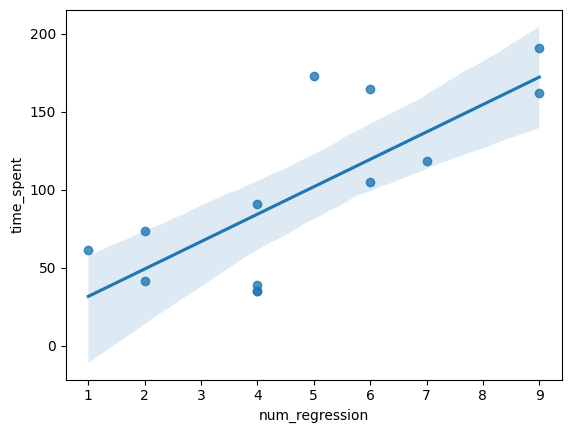


Intercept: 14.022413974855032
Slope: 17.55850961731701
                            OLS Regression Results                            
Dep. Variable:             time_spent   R-squared:                       0.585
Model:                            OLS   Adj. R-squared:                  0.547
Method:                 Least Squares   F-statistic:                     15.49
Date:                Thu, 13 Mar 2025   Prob (F-statistic):            0.00233
Time:                        11:19:45   Log-Likelihood:                -64.923
No. Observations:                  13   AIC:                             133.8
Df Residuals:                      11   BIC:                             135.0
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                     coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------

<ipython-input-21-6b1f31f1171d>:18: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  print("\nIntercept:", coefficients[0])
/usr/local/lib/python3.11/dist-packages/scipy/stats/_axis_nan_policy.py:418: UserWarning: `kurtosistest` p-value may be inaccurate with fewer than 20 observations; only n=13 observations were given.
  return hypotest_fun_in(*args, **kwds)


In [ ]:
linear_regression_chain()

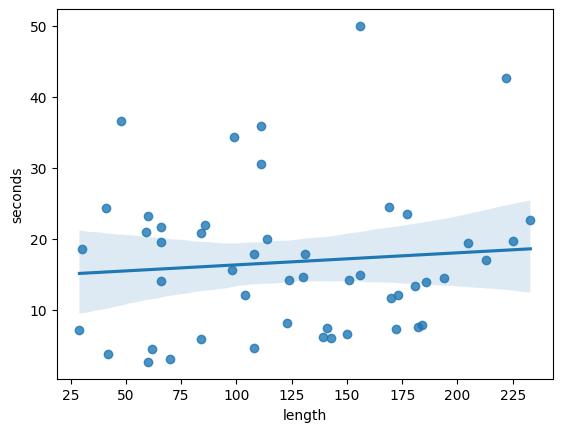


Intercept: 14.62380279367814
Slope: 0.016986766228667842
                            OLS Regression Results                            
Dep. Variable:                seconds   R-squared:                       0.008
Model:                            OLS   Adj. R-squared:                 -0.012
Method:                 Least Squares   F-statistic:                    0.4066
Date:                Thu, 13 Mar 2025   Prob (F-statistic):              0.527
Time:                        11:19:52   Log-Likelihood:                -187.43
No. Observations:                  50   AIC:                             378.9
Df Residuals:                      48   BIC:                             382.7
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------

<ipython-input-20-ffbb970122a1>:18: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  print("\nIntercept:", coefficients[0])


In [ ]:
linear_regression_chain_singles()

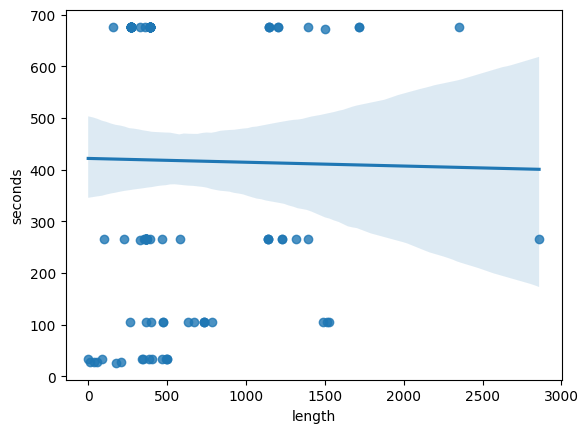


Intercept: 421.6350292597067
Slope: -0.007363087324085388
                            OLS Regression Results                            
Dep. Variable:                seconds   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                 -0.009
Method:                 Least Squares   F-statistic:                   0.01933
Date:                Thu, 13 Mar 2025   Prob (F-statistic):              0.890
Time:                        11:20:03   Log-Likelihood:                -757.19
No. Observations:                 108   AIC:                             1518.
Df Residuals:                     106   BIC:                             1524.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------

<ipython-input-19-d11ead8c5dc7>:19: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  print("\nIntercept:", coefficients[0])


In [ ]:
llama_name = 'meta-llama/Meta-Llama-3.1-8B-Instruct'

linear_regression_singles(llama_name)

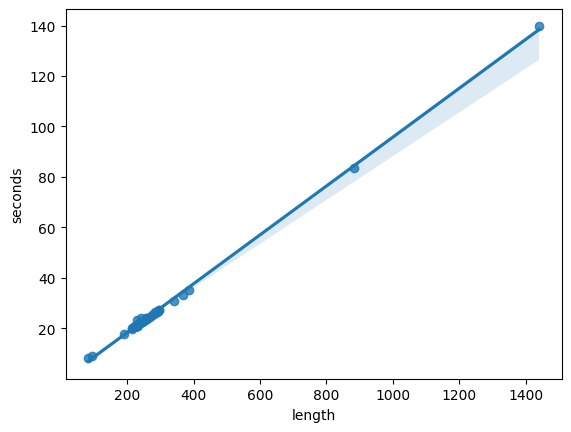


Intercept: -1.110990084102074
Slope: 0.09687842104472978
                            OLS Regression Results                            
Dep. Variable:                seconds   R-squared:                       0.999
Model:                            OLS   Adj. R-squared:                  0.999
Method:                 Least Squares   F-statistic:                 4.193e+04
Date:                Mon, 10 Mar 2025   Prob (F-statistic):           2.87e-77
Time:                        11:27:24   Log-Likelihood:                -52.452
No. Observations:                  54   AIC:                             108.9
Df Residuals:                      52   BIC:                             112.9
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------

<ipython-input-26-d11ead8c5dc7>:19: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  print("\nIntercept:", coefficients[0])


In [ ]:
deep_name = 'deepseek-ai/DeepSeek-Coder-V2-Lite-Instruct'

linear_regression_singles(deep_name)

In [ ]:
#clang -g --fsanitize=address,undefined,signed-integer-overflow -fno-sanitize-recover=all file.c